Here we attempt to show that the jackknife errors converge as the number of jackknives increase (now that we fixed the issue with the prior on shear).

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"


In [2]:
from tqdm import tqdm 

In [3]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

import numpy as np 

from bpd.utils import process_in_batches


In [4]:
seed = 99
g1 = 0.02 
g2 = 0.0

shape_noise = 0.02
sigma_e_int=0.05
sigma_m = 1e-5

In [5]:
# sample ellipticities

k = random.key(seed)
k1, k2, k3, k4 = random.split(k, 4 )
true_g = jnp.array([g1, g2])

In [6]:
e_obs_p, _, e_int = sample_noisy_ellipticities_unclipped(
    k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 100
)

e_obs_m, _, _ = sample_noisy_ellipticities_unclipped(
    k1, g=(-1) * true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 100
)

In [7]:
e_obs_p.shape, e_obs_m.shape

((10000, 2), (10000, 2))

In [8]:
def get_e1e2_post(key, e_obs_plus, e_obs_minus, *, sigma_e_int, sigma_m, n_samples=300):

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(key, e_obs_plus.shape[0])

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)

    return e1e2p, e1e2m

In [9]:
# now  obtain posteriors 
e1e2p, e1e2m = get_e1e2_post(k2, e_obs_p, e_obs_m, sigma_e_int=sigma_e_int, sigma_m=sigma_m)

In [10]:
e1e2p.shape, e1e2m.shape

((10000, 300, 2), (10000, 300, 2))

In [11]:
def get_shear(key, e1e2, *, shape_noise, sigma_e_int, n_samples:int=1000):
    
    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    return pipe(key, e1e2)

In [12]:
gp = get_shear(k3, e1e2p, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gp.shape

(1000, 2)

In [13]:
gm = get_shear(k3, e1e2m, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gm.shape

(1000, 2)

In [14]:
m = (gp[:, 0].mean() - gm[:, 0].mean()) / 2/ 0.02 -1
m

Array(3.50213662e-05, dtype=float64)

# Jackknife errors

In [15]:
n_gals = e1e2p.shape[0]
n_gals

10000

In [23]:
_pipe = vmap(jit(partial(get_shear, shape_noise=shape_noise, sigma_e_int=sigma_e_int)))

In [24]:
e1e2p.shape

(10000, 300, 2)

In [25]:
from tqdm import tqdm

n_jacks = 100


b1 = n_gals // n_jacks
assert n_jacks * b1 == n_gals
k3s = random.split(k3, n_jacks)

e1e2pj = [] 
e1e2mj = [] 
for ii in tqdm(range(n_jacks)):
    start, end = ii * b1, (ii + 1) * b1
    e1e2pj.append(jnp.concatenate([e1e2p[:start], e1e2p[end:]]))
    e1e2mj.append(jnp.concatenate([e1e2m[:start], e1e2m[end:]]))

e1e2pj = jnp.stack(e1e2pj, axis=0)
e1e2mj = jnp.stack(e1e2mj, axis=0)

        


100%|██████████| 100/100 [00:00<00:00, 1003.19it/s]


In [26]:
e1e2pj.shape

(100, 9900, 300, 2)

In [27]:
# jit pipe
_ = _pipe(k3s[0:1], e1e2pj[0:1])

In [30]:
# gpj  = _pipe(k3s, e1e2pj)

In [31]:
gpj = process_in_batches(_pipe, k3s, e1e2pj, n_points=n_jacks, batch_size=20)

Processing batches: 100%|██████████| 5/5 [09:50<00:00, 118.20s/it]


In [32]:
gmj = process_in_batches(_pipe, k3s, e1e2mj, n_points=n_jacks, batch_size=20)

Processing batches: 100%|██████████| 5/5 [09:43<00:00, 116.70s/it]


In [34]:
gpj.shape, gmj.shape

((100, 1000, 2), (100, 1000, 2))

In [35]:
mj = (gpj[:, :, 0].mean(1) - gmj[:, :, 0].mean(1)) / 2 / 0.02  - 1
mj.shape

(100,)

In [37]:
mj.mean(), mj.std()

(Array(5.96231418e-06, dtype=float64), Array(8.05922138e-05, dtype=float64))

In [38]:
gpj[:, :, 0].mean(), gp[:, 0].mean(), 

(Array(0.01984458, dtype=float64), Array(0.01985071, dtype=float64))

In [39]:
gmj[:, :, 0].mean(), gm[:, 0].mean(), 

(Array(-0.02015566, dtype=float64), Array(-0.02015069, dtype=float64))

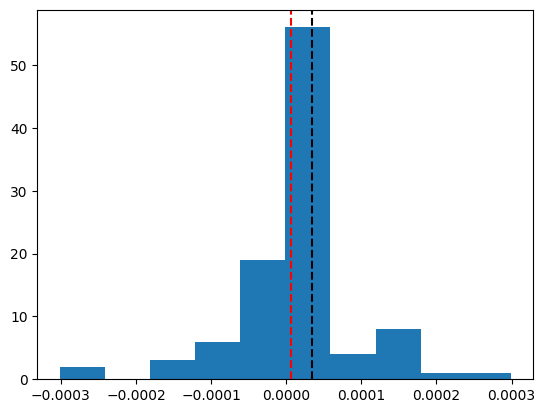

In [40]:
plt.hist(mj)
plt.axvline(m, c='k', ls='--')
plt.axvline(mj.mean(), c='r', ls='--')

In [41]:
m, mj.mean(), np.sqrt(mj.var() * (len(mj) - 1))

(Array(3.50213662e-05, dtype=float64),
 Array(5.96231418e-06, dtype=float64),
 np.float64(0.0008018824026078882))

## Jackknife convergence

In [152]:
n_jackss = (10, 50, 100, 200)
mjs = [] 

for n_jacks in tqdm(n_jackss):
    b1 = n_gals // n_jacks
    k3s = random.split(k3, n_jacks)

    e1e2pj = [] 
    e1e2mj = [] 
    for ii in range(n_jacks):
        start, end = ii * b1, (ii + 1) * b1
        e1e2pj.append(jnp.concatenate([e1e2p[:start], e1e2p[end:]]))
        e1e2mj.append(jnp.concatenate([e1e2m[:start], e1e2m[end:]]))

    e1e2pj = jnp.stack(e1e2pj, axis=0)
    e1e2mj = jnp.stack(e1e2mj, axis=0)

    gpj = vmap(_pipe)(k3s, e1e2pj)
    gmj = vmap(_pipe)(k3s, e1e2mj)
    mj = (gpj[:, :, 0].mean(1) - gmj[:, :, 0].mean(1)) / 2/ 0.02  - 1
    mjs.append(mj)

2025-04-11 10:08:13.999147: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.97GiB (rounded to 20371523328)requested by op 
2025-04-11 10:08:13.999429: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****___***_________________********_______*********_________________________________________________
E0411 10:08:13.999451 1272324 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20371523176 bytes.
 80%|████████  | 4/5 [08:42<02:10, 130.61s/it]


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20371523176 bytes.

In [153]:
len(mjs)

4

In [177]:
mj_means  = [mj.mean() for mj in mjs]
mj_sigmas = [np.sqrt(mj.var() * (len(mj) - 1)) for mj in mjs]

In [181]:
len(mjs[0])

10

In [183]:
# explicit expression
[ np.sqrt((len(mj) - 1) / len(mj) * np.sum( (mj - mj.mean())**2 ) ) for mj in mjs]

[np.float64(0.0009992877813459233),
 np.float64(0.0020501438904605746),
 np.float64(0.003166261437133035),
 np.float64(0.0033813438725487925)]

In [178]:
mj_means, mj_sigmas

([Array(-0.00012086, dtype=float64),
  Array(-4.64712922e-05, dtype=float64),
  Array(1.00987258e-05, dtype=float64),
  Array(2.88625318e-05, dtype=float64)],
 [np.float64(0.0009992877813459233),
  np.float64(0.002050143890460574),
  np.float64(0.003166261437133035),
  np.float64(0.0033813438725487925)])

Array(0.0002397, dtype=float64)

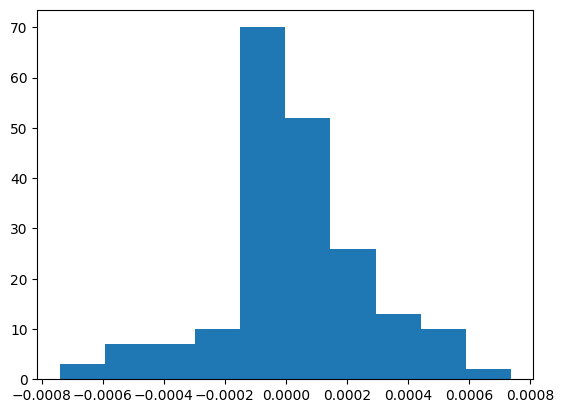

In [180]:
plt.hist(mjs[-1])
mjs[-1].std()

# Bootstrap comparison

In [57]:
n_boots = 100
n_gals

10000

In [62]:
_pipe = jit(partial(get_shear, shape_noise=shape_noise, sigma_e_int=sigma_e_int))

In [58]:
k3s = random.split(k3, n_boots)
k4s = random.split(k4, n_boots)

In [65]:
gpbs = [] 
gmbs = [] 

for ii in tqdm(range(n_boots)):
    indices = random.choice(k4s[ii], jnp.arange(len(e1e2p)), shape=(n_gals,), replace=True)
    _gpb = _pipe(k3s[ii], e1e2p[indices])   
    _gmb = _pipe(k3s[ii], e1e2m[indices])

    gpbs.append(_gpb)
    gmbs.append(_gmb)

100%|██████████| 100/100 [21:50<00:00, 13.11s/it]


In [64]:
# # e1e2pb = e1e2p[indices]
# # e1e2mb = e1e2m[indices]
# e1e2pb.shape

In [107]:
# gpb = vmap(_pipe, in_axes=(None, 0))(k3, e1e2pb)

In [108]:
# gmb = vmap(_pipe, in_axes=(None, 0))(k3, e1e2mb)

In [66]:
gpb = jnp.stack(gpbs, axis=0)

In [67]:
gmb = jnp.stack(gmbs, axis=0)

In [68]:
gpb.shape, gmb.shape

((100, 1000, 2), (100, 1000, 2))

In [69]:
mb = (gpb[:, :, 0].mean(1) - gmb[:, :, 0].mean(1)) / 2/ 0.02  - 1

In [70]:
mb.shape

(100,)

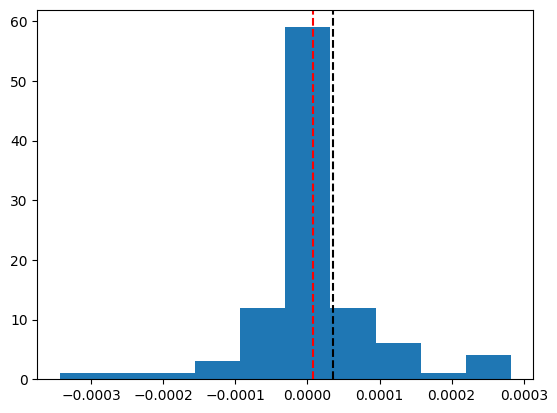

In [71]:
plt.hist(mb)
plt.axvline(m, c='k', ls='--')
# plt.axvline(mjs[-1].mean(), c='bx', ls='--')
plt.axvline(mb.mean(), c='r', ls='--')

In [72]:
mb.mean(), mb.std()

(Array(7.16853987e-06, dtype=float64), Array(8.64939272e-05, dtype=float64))

# Summary

In [74]:
m, mj.mean(), mb.mean()

(Array(3.50213662e-05, dtype=float64),
 Array(5.96231418e-06, dtype=float64),
 Array(7.16853987e-06, dtype=float64))

In [77]:
mj.std()

(Array(8.05922138e-05, dtype=float64), 100)

In [75]:
np.sqrt(mj.var() * (len(mj) - 1)), mb.std()

(np.float64(0.0008018824026078882), Array(8.64939272e-05, dtype=float64))

# Look at mean of posteriors on shear

In [78]:
gpj.shape, gpb.shape

((100, 1000, 2), (100, 1000, 2))

In [81]:
np.sqrt(gpj[...,0].mean(1).var()  * (len(gpj) - 1) )

np.float64(0.0002049215219508461)

In [82]:
gpb[...,0].mean(1).std()

Array(0.00020265, dtype=float64)

In [119]:
# they agree!

# Misc

(array([  3.,   2.,   8., 972.,   5.,   3.,   1.,   3.,   2.,   1.]),
 array([-0.00873138, -0.00634588, -0.00396038, -0.00157487,  0.00081063,
         0.00319613,  0.00558163,  0.00796713,  0.01035263,  0.01273813,
         0.01512363]),
 <BarContainer object of 10 artists>)

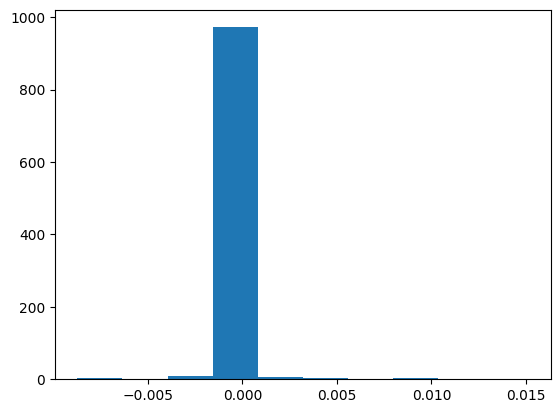

In [84]:
m_post = (gp[:, 0] - gm[:, 0]) / 2/ 0.02 - 1
plt.hist(m_post)

In [128]:
m_post.mean(), m_post.std() / np.sqrt(1000 )

(Array(3.50213662e-05, dtype=float64), Array(3.28352935e-05, dtype=float64))

In [129]:
import math
import numpy as np
def do_jack(x, fnc, n_jacks=10):
    assert x.ndim == 1
    n = x.shape[0]
    b = math.ceil(n / n_jacks)

    res = [] 
    for ii in range(n_jacks):
        idx1, idx2 = ii * b, (ii+1) * b
        _x = jnp.concatenate([x[:idx1], x[idx2:]])
        res.append(fnc(_x))
    res = np.array(res)
    return np.sqrt(np.var(res) * (n_jacks-1))

In [131]:
import math
import numpy as np
def do_boot(x, fnc, n_boots=500):
    assert x.ndim == 1
    n = x.shape[0]

    res = [] 
    for ii in range(n_boots):
        indices = np.random.choice(np.arange(n), size=(n,), replace=True)
        res.append(fnc(x[indices]))
    res = np.array(res)
    return np.std(res)

In [130]:
do_jack(m_post, np.mean, n_jacks=100)

np.float64(3.299885864739951e-05)

In [136]:
do_boot(m_post, np.mean)

np.float64(3.348408705413145e-05)

## What is ESS

In [ ]:
from arviz import ess


In [98]:
_k3s = random.split(k3, 4)

In [99]:
pipe = jit(partial(get_shear, shape_noise=shape_noise , sigma_e_int=sigma_e_int))

In [101]:
gp = vmap(pipe, in_axes=(0, None))(_k3s, e1e2p)

In [102]:
gm = vmap(pipe, in_axes=(0, None))(_k3s, e1e2m)

In [104]:
gp.shape

(4, 1000, 2)

In [105]:
m_chains = (gp[:, :, 0] - gm[:, :, 0]) / 2/ 0.02 -1
m_chains.shape

(4, 1000)

In [125]:
_ess_g = ess(np.asarray(gm[:, :, 0]))
_ess_g

np.float64(3167.904980371274)

In [126]:
_ess_m = ess(np.asarray(m_chains))
_ess_m

np.float64(4015.299315663907)

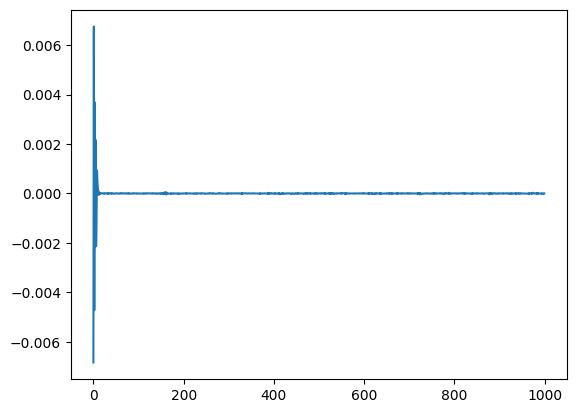

In [127]:
plt.plot(m_chains[0, :])